Давайте подивимося, як LSTM можна використовувати для побудови нейронної мережі прогнозування часових рядів.

Будемо працювати з задачею прогнозування кількості пасажирів міжнародних авіаліній. З цим набором даних ми вже працювали в лекції "Time Series Analysis" і ви зможете порівняти результати :)

Задача полягає в тому, щоб за заданими роком і місяцем передбачити кількість пасажирів міжнародних авіаліній в одиницях виміру 1,000. Дані охоплюють період з січня 1949 року по грудень 1960 року, тобто 12 років, зі 144 спостереженнями.

Це регресійна задача. Тобто, знаючи кількість пасажирів (в тисячах) за останні місяці, можна передбачити, якою буде кількість пасажирів у наступному місяці. Набір даних має лише одну характеристику: "Кількість пасажирів" - `Passengers`.

Далі вже наведений код для читання даних, але нам їх ще треба буде трошки обробити.

### Imports

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader

### Load the data

In [44]:
# Завантаження даних
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.set_index('Month', inplace=True)
display(df.head())

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


### **Завдання 1.**
Створіть змінну типу `numpy.ndarray`, яка містить значення кількості пасажирів в форматі `float32`. Такий формат даних нам треба для тренування нейромережі.

In [45]:
num_pessengers = df.values.astype(np.float32)
num_pessengers[:5]

array([[112.],
       [118.],
       [132.],
       [129.],
       [121.]], dtype=float32)

Очікуваний результат:
```array([112., 118., 132., 129., 121.], dtype=float32)```

### **Завдання 2**. train, test
Розбийте дані на тренувальні і валідаційні у співвідношенні 67% йде у тренування, 33 - у валідацію. Памʼятаємо, що ми працюємо з tim series, відповідно, навчаємось на давніших, валідуємось - на новіших.

In [46]:
split_idx = int((len(num_pessengers)/3))
split_idx

48

In [47]:
train = num_pessengers[:-split_idx]
test = num_pessengers[-split_idx:]

In [48]:
print("train:", len(train))
print("test:", len(test))

train: 96
test: 48


### **Завдання 3**. create_dataset

Реалізуйте функцію `create_dataset`, яка перетворить одномірний часовий ряд (набір даних) у формат, придатний для тренування нейромережі.

Функція повинна приймати два аргументи:
- `dataset` — numpy-масив часового ряду,
- `lookback` — кількість попередніх кроків, які використовуватимуться для передбачення.

Функція повинна повернути два **тензори** PyTorch:
- `X` — набір ознак (вікно попередніх значень),
- `y` — цільові значення (наступні після вікна кроки).

Дані ми будемо подавати моделі в наступному форматі:
`
tensor([[112.],
        [118.],
        [132.],
        [129.],
        [121.]])
`
Відповідно першою розмірністю буде йти розмір вхідного батча, а другою - розмір вхідних даних і в нас це 1, бо лише одне значення на вході щоразу.

Після виконання завдання запустіть код нижче. Ми будемо передбачати на основі кількості пасажирів в попередній день кількість пасажирів в наступний, тому `lookback == 1`.

In [49]:
def create_dataset(dataset, lookback):
    X = torch.from_numpy(dataset[:-lookback])
    y = torch.from_numpy(dataset[lookback:])
    return X, y

In [50]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])


Очікуваний результат:
```
torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])
```

### **Завдання 4**. AirModel

Зверніть увагу на розмірності в попередньому завданні.
За допомогою модуля `torch.nn` опишіть клас `AirModel`, який є нейронною мережею для прогнозування кількості пасажирів за допомогою LSTM.

1. **Конструктор класу** повинен приймати параметри `hidden_size`, `num_layers` та ініціювати шари:
   - LSTM-шар з наступними параметрами:
     - `input_size` — кожна точка часового ряду є окремим входом,,
     - `hidden_size` — заданий в конструкторі класу мережі,
     - `num_layers=1` — кількість шарів LSTM, задана в конструкторі мережі,
     - `batch_first=True` — визначає, що першим виміром є розмір батчу.
   - Лінійний шар (`nn.Linear`) для перетворення виходу LSTM на прогноз однієї точки.

2. **Метод forward** повинен виконувати наступні дії:
   - Передати вхідний тензор через LSTM-шар і отримати виходи (ігноруючи приховані стани).
   - Пропустити вихід LSTM через лінійний шар для отримання остаточного прогнозу.

Створіть об'єкт класу `AirModel` зі значеннями параметрів `hidden_size=50`, `num_layers=1` і протестуйте роботу моделі на вхідному тензорі `tensor([[112.]])`. На цьому етапі ми маємо переконатись, що модель здатна генерувати передбачення з рандомно ініційованими вагами.

In [51]:
class AirModel(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size=lookback,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, out_features=1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

In [52]:
hidden_size = 50
num_layers = 1

model = AirModel(hidden_size, num_layers)
model

AirModel(
  (lstm): LSTM(1, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [53]:
model(torch.tensor([[112.]]))

tensor([[0.2914]], grad_fn=<AddmmBackward0>)

### **Завдання 5**. Dataloader

Створіть об'єкт DataLoader для завантаження даних, використовуючи тренувальні вибірки `X_train` та `y_train`. Ваш DataLoader повинен виконувати наступні вимоги:

1. Використовувати клас `TensorDataset`, щоб об'єднати тензори ознак `X_train` і цільових значень `y_train`.
2. Дані повинні завантажуватися невеликими батчами розміром 8 за допомогою параметра `batch_size`.
3. Використовувати параметр `shuffle=True`, щоб дані перемішувалися перед кожною епохою тренування.


In [54]:
batch_size = 8

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train_ds, batch_size, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size, shuffle=True)

### **Завдання 6**. Train the AirModel

1. Реалізуйте навчання нейронної мережі `AirModel` для прогнозування часових рядів, використовуючи Adam-оптимізатор та функцію втрат MSE (середньоквадратичну похибку).
2. Створіть цикл тренування для 2000 епох, у якому на кожній епосі:
   - Виконуйте крок тренування моделі (прямий прохід, обчислення похибки, зворотний прохід і оновлення ваг).
   - Підраховуйте середню похибку на кожному батчі даних і зберігайте її у списку `losses`.
3. Раз на 100 епох проводьте валідацію моделі:
   - Перевіряйте модель на тренувальних та тестових даних без оновлення ваг.
   - Обчислюйте корінь середньоквадратичної похибки (RMSE) для тренувальної та тестової вибірок і виводьте результати на екран.
   
**Примітка:**
- Використовуйте вже створений `DataLoader` для отримання батчів даних.
- Валідацію виконуйте в режимі `eval()`, вимикаючи обчислення градієнтів з `torch.no_grad()`.

**Приклад виходу:**
```
Epoch 0: train RMSE 12.3456, test RMSE 15.6789
Epoch 100: train RMSE 9.8765, test RMSE 12.3456
...
```

In [55]:
num_epochs = 2000

In [56]:
loss_fn = F.mse_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [57]:
def train_eval(num_epochs, model, dataloader, loss_fn, optimizer):
    total_losses = []
    for epoch in range(num_epochs + 1):
        epoch_loss = 0
        model.train()

        for X, y in dataloader:
            # Zero gradients
            optimizer.zero_grad()

            # Compute the prediction error
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Calculate loss
        avg_loss = epoch_loss / len(dataloader)
        total_losses.append(avg_loss)

        if (epoch) % 100 == 0:
            model.eval()

            with torch.no_grad():
                # Compute the prediction error
                train_pred = model(X_train)
                train_rmse = torch.sqrt(loss_fn(train_pred, y_train))

                test_pred = model(X_test)
                test_rmse = torch.sqrt(loss_fn(test_pred, y_test))
            print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}")

    return total_losses

In [58]:
total_losses = train_eval(num_epochs, model, train_dataloader, loss_fn, optimizer)

Epoch 0: train RMSE 225.6121, test RMSE 422.0310
Epoch 100: train RMSE 175.4243, test RMSE 369.4464
Epoch 200: train RMSE 137.0869, test RMSE 327.5070
Epoch 300: train RMSE 106.1139, test RMSE 290.4937
Epoch 400: train RMSE 84.3406, test RMSE 258.8195
Epoch 500: train RMSE 65.9427, test RMSE 231.5165
Epoch 600: train RMSE 48.9924, test RMSE 199.8363
Epoch 700: train RMSE 38.7696, test RMSE 175.5822
Epoch 800: train RMSE 32.9391, test RMSE 154.9801
Epoch 900: train RMSE 27.8870, test RMSE 136.8468
Epoch 1000: train RMSE 25.5160, test RMSE 123.2827
Epoch 1100: train RMSE 24.3821, test RMSE 112.9573
Epoch 1200: train RMSE 22.9945, test RMSE 104.4670
Epoch 1300: train RMSE 23.0551, test RMSE 96.9249
Epoch 1400: train RMSE 22.9959, test RMSE 92.7075
Epoch 1500: train RMSE 22.7340, test RMSE 89.8511
Epoch 1600: train RMSE 22.1748, test RMSE 89.4736
Epoch 1700: train RMSE 22.8372, test RMSE 88.6416
Epoch 1800: train RMSE 23.3924, test RMSE 82.8874
Epoch 1900: train RMSE 22.3930, test RMSE 83.

### **Завдання 7.** Plot for Loss 
Побудуйте графік лосів. Зробіть висновок з графіку, чи навчилась модель?

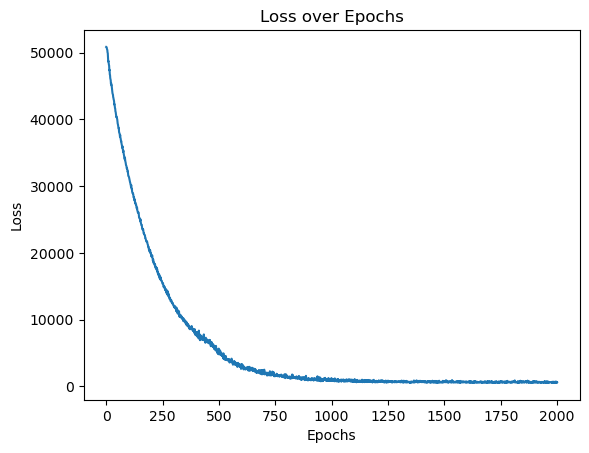

In [59]:
plt.plot(total_losses)
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Щоб краще зрозуміти якість прогнозу, ви можете побудувати графік з кодом нижче (а ще нижче - описано, що відбувається в цьому коді, бо це теж корисно зрозуміти):

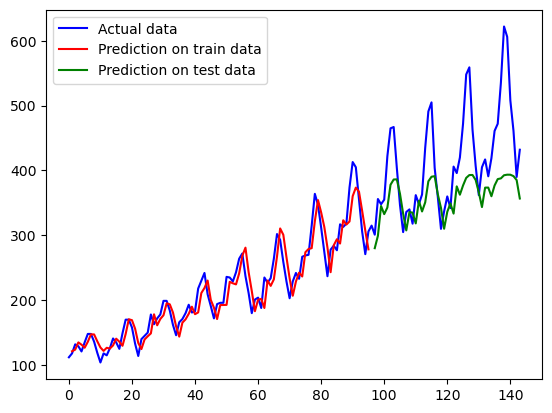

In [60]:
def plot_predicts():
    with torch.no_grad():
        train_size = len(train)
        train_plot = np.ones_like(num_pessengers) * np.nan
        train_plot[lookback:train_size] = model(X_train)[:, -1].unsqueeze(-1)

        test_plot = np.ones_like(num_pessengers) * np.nan
        test_plot[train_size + lookback:] = model(X_test)[:, -1].unsqueeze(-1)

        plt.plot(num_pessengers, 'b', label='Actual data')
        plt.plot(train_plot, 'r', label='Prediction on train data')
        plt.plot(test_plot, 'g', label='Prediction on test data')
        plt.legend()
        plt.show()

plot_predicts()

The model performs well on train data, but worst on test data.

### **Завдання 8**. Train the Model with hidden_size=100
Навчіть модель з hidden_size=100 та порівняйте результати прогнозів з попередніми.

In [64]:
model_100 = AirModel(hidden_size=100, num_layers=1)
loss_fn = F.mse_loss
optimizer = torch.optim.Adam(model_100.parameters(), lr=0.001)

In [65]:
total_losses_100 = train_eval(num_epochs, model_100, train_dataloader, loss_fn, optimizer)

Epoch 0: train RMSE 225.0142, test RMSE 421.6159
Epoch 100: train RMSE 133.2765, test RMSE 323.1762
Epoch 200: train RMSE 84.4836, test RMSE 259.0783
Epoch 300: train RMSE 55.2189, test RMSE 212.9142
Epoch 400: train RMSE 36.5520, test RMSE 170.0310
Epoch 500: train RMSE 30.0478, test RMSE 143.9541
Epoch 600: train RMSE 25.6597, test RMSE 122.3591
Epoch 700: train RMSE 24.1043, test RMSE 109.6484
Epoch 800: train RMSE 23.4665, test RMSE 100.8365
Epoch 900: train RMSE 23.0313, test RMSE 94.5268
Epoch 1000: train RMSE 22.9428, test RMSE 87.1550
Epoch 1100: train RMSE 22.7190, test RMSE 86.0268
Epoch 1200: train RMSE 22.7497, test RMSE 79.3284
Epoch 1300: train RMSE 22.6928, test RMSE 78.2297
Epoch 1400: train RMSE 22.6294, test RMSE 77.5455
Epoch 1500: train RMSE 22.7869, test RMSE 72.4900
Epoch 1600: train RMSE 22.5830, test RMSE 74.2131
Epoch 1700: train RMSE 23.0278, test RMSE 75.2659
Epoch 1800: train RMSE 22.6271, test RMSE 71.7237
Epoch 1900: train RMSE 22.3656, test RMSE 75.7873
E

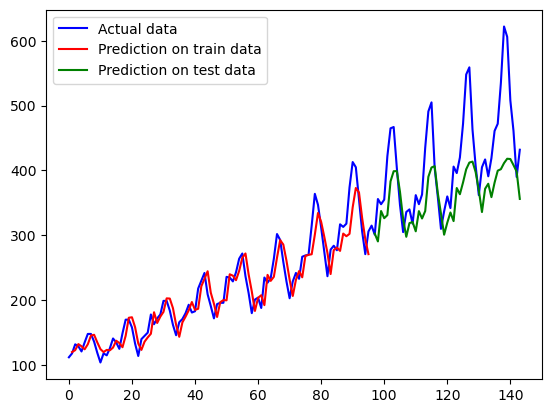

In [74]:
with torch.no_grad():
    train_size = len(train)
    train_plot = np.ones_like(num_pessengers) * np.nan
    train_plot[lookback:train_size] = model_100(X_train)[:, -1].unsqueeze(-1)

    test_plot = np.ones_like(num_pessengers) * np.nan
    test_plot[train_size + lookback:] = model_100(X_test)[:, -1].unsqueeze(-1)

    plt.plot(num_pessengers, 'b', label='Actual data')
    plt.plot(train_plot, 'r', label='Prediction on train data')
    plt.plot(test_plot, 'g', label='Prediction on test data')
    plt.legend()
    plt.show()

The model with `hidden_size=100` performs slightly better: test RMSE 71.7237 vs. test RMSE 80.8585.